# VM: Deep Learning mit Python

*Group: Leo Giesen, Johannes Kauffmann*

Case Study: Create deep learning model to predict Land Use and Land Cover data drom satellite pictures.

In [137]:
# Imports

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import calendar
import os
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

**Define class names and channel names**

In [138]:
# Class names

class_names = {
    0: "No Data", 
    1: "Cultivated Land",
    2: "Forest",
    3: "Grassland",
    4: "Shrubland",
    5: "Water",
    6: "Wetlands",
    7: "Tundra",
    8: "Artificial Surface",
    9: "Bareland",
    10: "Snow and Ice"
}

In [139]:
# Channel names

channel_names = {
    1: "Red",
    2: "Green",
    3: "Blue",
    4: "NIR 1",
    5: "NIR 2",
    6: "NIR 3"
}

**Loading data**

In [ ]:
data = np.load('../data/train.npz')
bands = data['bands'] # data: 10.000 patches, each for twelve months and with six channels. Resolution: 33x33 pixels
lulc = data['lulc'] # labels for central pixel of patches (Land Use and Land Cover)
#print(bands.shape)
print(lulc.shape)

In [178]:
print(lulc.shape)

(10000,)


In [198]:
count_classes = []
for i in range(11): 
    val = np.count_nonzero(lulc == i)
    print("class "+str(i)+": "+str(val))
    count_classes.append(val)
#print(count_classes)

class 0: 1308
class 1: 238
class 2: 5796
class 3: 1125
class 4: 770
class 5: 58
class 6: 0
class 7: 0
class 8: 217
class 9: 488
class 10: 0


Realization: Class 2 is really over-represented. Classes 6, 7 and 10 are not present in the data set at all

Channels from patch no. 250
Central pixel is labeled as Cultivated Land


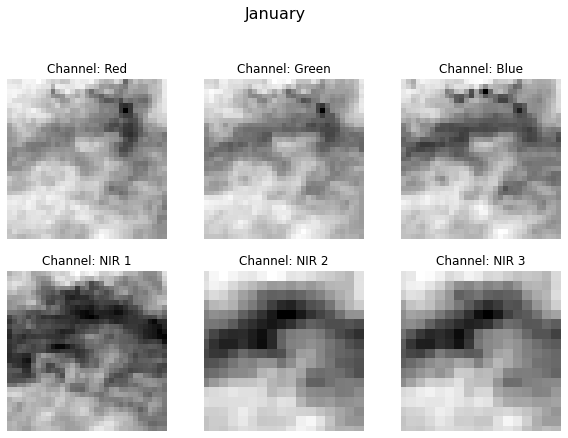

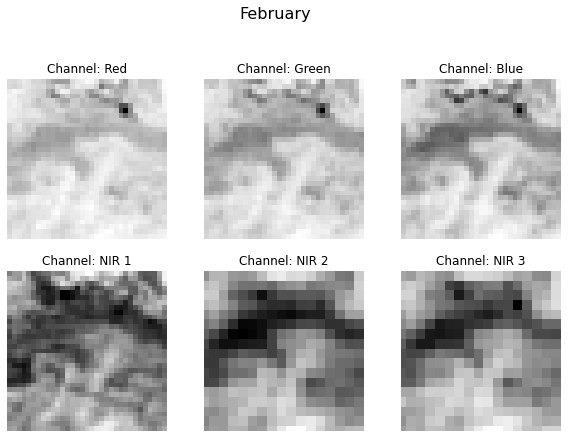

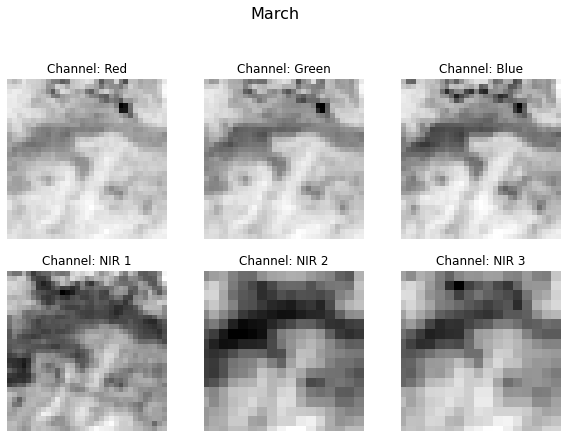

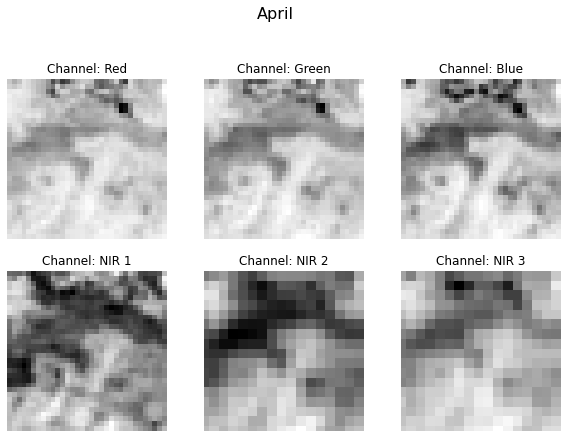

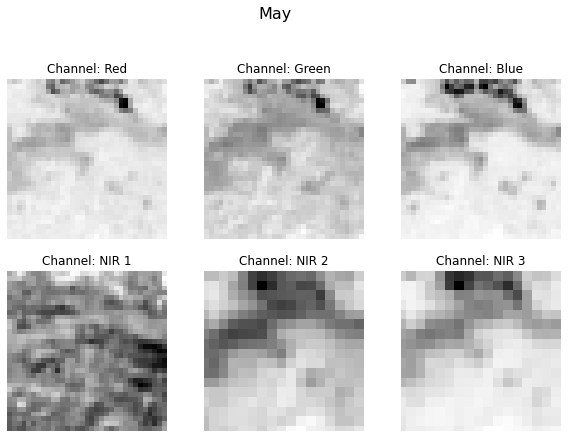

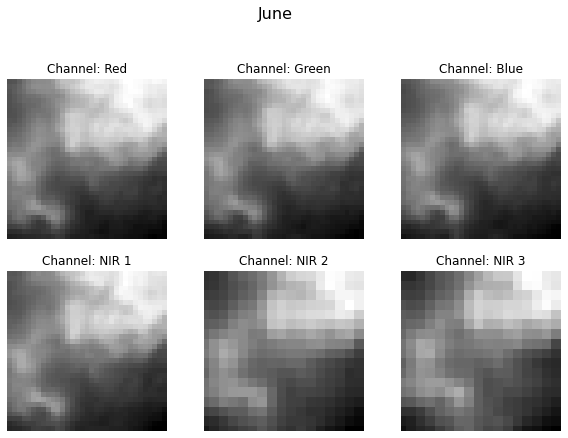

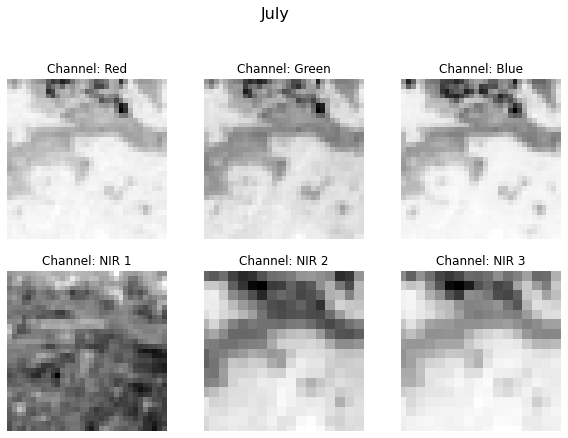

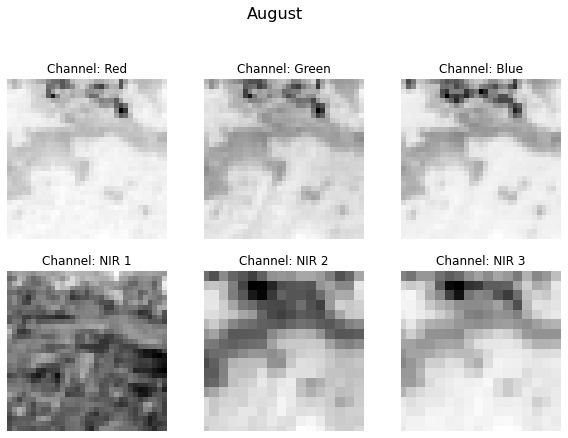

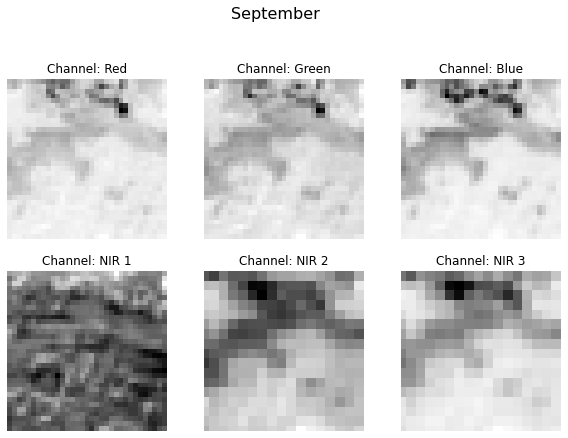

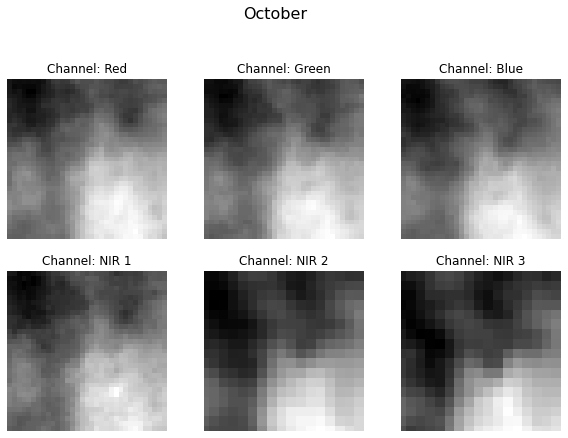

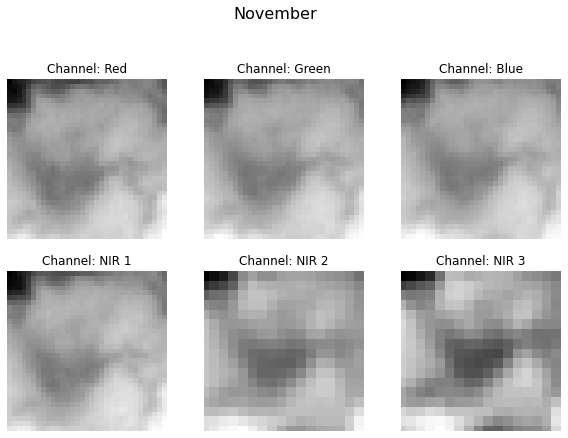

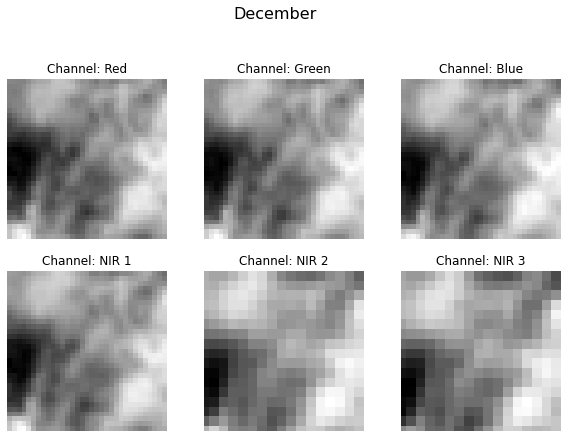

In [143]:
# Show some images

patch = 250 # patch number

print("Channels from patch no. " + str(patch))
print("Central pixel is labeled as " + class_names[lulc[patch]])

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands[patch, month, :, :, channel]
        plt.imshow(image, cmap = plt.cm.binary)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off")

**Preprocessing**

In [145]:
# Generating test, validation and training sets
X = bands
y = lulc
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.20)

In [238]:
#Small image dataset -> sample diversity: random & realistic transformations to training images (rotation & horizontal flipping) -> reduce overfitting
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

**Build the 3D CNN Model**

adapted by: https://towardsdatascience.com/step-by-step-implementation-3d-convolutional-neural-network-in-keras-12efbdd7b130

In [240]:
model = Sequential() # sequential model
model.add(tf.keras.Input(shape=(12, 33, 33, 6)))
model.add(data_augmentation)
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(12,33,33,6)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_uniform')) #leaky relu and not standard one
model.add(Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_uniform')) #leaky relu and not standard one
model.add(Dense(11, activation='softmax')) # number of outputs, in our case eleven different classes

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

**Calculate class weights automatically** 

In [235]:
from sklearn.utils import class_weight
classes = np.array([x for x in range(0,11)])
class_weights_array = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
#automatic conversion to dictionarry does not work since not represented 
#classes are not included in the class_weights array
#dict_class_weights = dict(enumerate(clsass_weights.flatten(), 0))

#class_weights_dict = {i : class_weights_array[i] for i in range(8)}
class_weights_dict = {
    0: class_weights_array[0],
    1: class_weights_array[1],
    2: class_weights_array[2],
    3: class_weights_array[3],
    4: class_weights_array[4],
    5: class_weights_array[5],
    6: 0,
    7: 0,
    8: class_weights_array[6],
    9: class_weights_array[7],
    10: 0,
}
#class_weights_array
class_weights_dict

{0: 0.9696969696969697,
 1: 5.517241379310345,
 2: 0.21304926764314247,
 3: 1.1204481792717087,
 4: 1.629327902240326,
 5: 21.05263157894737,
 6: 0,
 7: 0,
 8: 6.299212598425197,
 9: 2.622950819672131,
 10: 0}

In [236]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, 
                    validation_data=(X_val, y_val),
                    class_weight=class_weights_dict)

Epoch 1/5
200/200 [==============================] - 235s 1s/step - loss: 2.9519 - accuracy: 0.2173 - val_loss: 1.8197 - val_accuracy: 0.2194
Epoch 2/5
184/200 [==========================>...] - ETA: 17s - loss: 1.6735 - accuracy: 0.3400

KeyboardInterrupt: 

In [12]:
#model.save('../modelels/trainingData_5Epochs.h5') # save model in root directory
model = keras.models.load_model('../modelels/trainingData_5Epochs.h5')

**Evaluation**

In [ ]:
# Calculate loss and accuracy
model.evaluate(X_test, y_test)
#63/63 [==============================] - 18s 288ms/step - loss: 0.8801 - accuracy: 0.6990

# Predicitions with test-set
y_pred = model.predict_classes(X_test)
plt.figure(figsize=(10, 10))
print("Predictions of Channel Red in January for nine test pictures:")
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_test[i, 0, :, :, 0], cmap = plt.cm.binary)
  plt.title("Predicition: " + str(y_pred[i]) + "; True label: " + str(y_test[i]))
  plt.axis("off")

In [ ]:
#Plot accuracy and loss of train and val set
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(history.history['accuracy'], color="green")
plt.plot(history.history['val_accuracy'], color="blue")
plt.title("Accuracy", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'], color="red",)
plt.plot(history.history['val_loss'], color="orange")
plt.title("Loss", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

**Testing on Public Test Set**

In [48]:
data_public_test = np.load('../data/public_test.npz') # load public test set
bands_public_test = data_public_test['bands'] # extract only layer called 'bands'
bands_public_test.shape

(12, 500, 500, 6)

**Padding**

In [49]:
bands_public_test_pad = np.zeros(shape=(12, 532, 532, 6)) # get empty array with correct shape

# perform padding for all images (months and channels)
for month in range(12):
    for channel in range(6):
        bands_public_test_pad[month, :, :,channel] = np.pad(bands_public_test[month, :, :,channel], ((16,16),(16,16)), 'constant')

# test padding

# for month in range(12):
#     plt.figure(figsize=(10, 10))
#     for channel in range(6): #show all six channels
#         ax = plt.subplot(3, 3, channel+1)
#         image = bands_public_test_pad[month, :, :, channel]
#         plt.imshow(image)
#         plt.title("Channel: " + channel_names[channel+1])
#         plt.suptitle(calendar.month_name[month+1], size=16)
#         plt.axis("off") 
        
# bands_public_test_pad.shape

NameError: name 'channel_names' is not defined

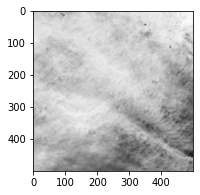

In [50]:
# Show all 12 monthly images of the public test set

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands_public_test[month, :, :, channel]
        plt.imshow(image, cmap = plt.cm.binary)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off")

In [52]:
# add one dimension to be able feeding our model

bands_public_test = np.expand_dims(bands_public_test, 0)
bands_public_test.shape

(1, 12, 500, 500, 6)

**Naive sliding window approach**

Iterate the model over the whole public test image with stepsize one.

In [237]:
x_coord_start = -1
x_coord = 32

#print(current_cutout.shape) #(1, 12, 33, 33, 6)
y_pred_public_test = np.zeros(shape=(532, 532, 1)) #468 nachher?

for i in range(60):
    x_coord += 1
    x_coord_start += 1
    y_coord_start = -1
    y_coord = 32
    for j in range(60):
        y_coord += 1
        y_coord_start += 1
        # pass every month & color channel 
        current_cutout = bands_public_test[:, :, x_coord_start:x_coord, y_coord_start:y_coord, :]
        
        #Debugging
        #print("i: "+str(i)+"  j: "+str(j)+"  -  "+str(x_coord_start)+":"+str(x_coord)+"; "+str(y_coord_start)+":"+str(y_coord))
        #if(current_cutout.shape != (1, 12, 33, 33, 6)): 
            #print(str(current_cutout.shape) + "\n")
        
        y_pred = model.predict_classes(current_cutout)
        y_pred_public_test[i][j] = y_pred[0]

KeyboardInterrupt: 

In [ ]:
s = 0
for i in range(60):
    for j in range(60):
        print("i: " + str(s+i) + "; j: " + str(s+j) + "; pred: " + str(int(y_pred_public_test[s+i][s+j])))

In [60]:
y_pred_public_test.shape
#plt.imshow(y_pred_public_test[:][:][0], cmap = plt.cm.binary)
plt.imsave('public_test_pred.png', y_pred_public_test)

# import tensorflow_hub as hub


# base_model = hub.load("https://tfhub.dev/google/remote_sensing/eurosat-resnet50/1")
# model = tf.keras.Sequential([
#   base_model, Dense(11, activation='softmax')])

ValueError: Third dimension must be 3 or 4